A non-negative real-valued continuous random variable is said to follow a linear hazard rate distribution, with parameter pair $\theta = (\alpha, \beta)$, if it has probability density function

$$
f(t \mid \theta) = (\alpha + \beta t) \exp\left(-\alpha t - \frac{\beta}{2} t^2\right), \quad t \geq 0.
$$

Suppose exchangeable event time data $\pmb{x} = (x_1, \ldots, x_n)$ are obtained during an observation interval $[0, t]$, $t > 0$, such that conditional on $t$, independently

$$
x_i \sim \text{Uniform}[0, t], \quad i = 1, \ldots, n.
$$

Further suppose the length of the observation interval is unknown, but that prior beliefs about $t$ are described by a linear hazard rate distribution with $\alpha = 0$, $\beta = 1$.

**Likelihood density:**

Since $x_i$ are independent,

$$
p ( \pmb{x} \, | \, t ) = \prod_{i=1}^{n} p(x_i \, | \, t).
$$

Since $x_i \sim \text{Uniform}[0, t]$,

$$
p(x_i \, | \, t) = \frac{1}{t} \mathbb{1}_{[0, t]}(x_i).
$$

Therefore,

$$
p ( \pmb{x} \, | \, t ) = \frac{1}{t^n} \mathbb{1}_{[0, t]^n}(\pmb{x}).
$$

This is equivalent to

$$
p ( \pmb{x} \, | \, t ) = \frac{1}{t^n} \mathbb{1}_{[0, t]}(x_{(n)}).
$$

**Maximum likelihood estimator:**

Since $t \geq x_{(n)}$, the likelihood function is

$$
L ( t ) = \frac{1}{t^n} \mathbb{1}_{[x_{(n)}, \infty)}(t).
$$

So $L ( t ) > 0$ for all $t \in [x_{(n)}, \infty)$.

Furthermore,

$$
\frac{dL}{dt} = -\frac{n}{t^{n+1}} \mathbb{1}_{[x_{(n)}, \infty)}(t).
$$

So $L ( t )$ is a decreasing function for all $t \in [x_{(n)}, \infty)$.

Therefore, the maximum likelihood estimator of $t$ is $x_{(n)}$.

**Posterior density:**

$$
\pi (t) \propto p ( \pmb{x} \, | \, t ) f ( t ).
$$

From above,

$$
p ( \pmb{x} \, | \, t ) = \frac{1}{t^n} \mathbb{1}_{[x_{(n)}, \infty)}(t).
$$

Prior beliefs about $t$ are described by a linear hazard rate distribution with $\alpha=0, \beta=1$. That is,

$$
f ( t ) = t \exp \left( -\frac {1} {2} t^2 \right).
$$

Therefore,

$$
\begin{array}{rcl}
\pi (t) & \propto & \frac{1}{t^n} \mathbb{1}_{[x_{(n)}, \infty)}(t) t \exp \left( -\frac {1} {2} t^2 \right) \\\\
& = & t^{1-n} \exp \left( -\frac {1} {2} t^2 \right) \mathbb{1}_{[x_{(n)}, \infty)}(t).
\end{array}
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def pi(t, n, x_max):
    '''Compute the (unnormalised) posterior density.'''
    if t >= x_max:
        return t**(1-n) * np.exp(-0.5 * t**2)
    else:
        return 0

def q(t_prime, t, delta):
    '''Compute the proposal density.'''
    if t - delta <= t_prime <= t + delta:
        return 1 / (2 * delta)
    else:
        return 0

def metropolis_hastings(n, x_max, delta, M, burn_in):
    '''Perform Metropolis-Hastings MCMC sampling.'''
    samples = np.zeros(M)
    accept_count = 0
    # Step 1: Initialise the Markov chain at a sensible starting value
    # I have chosen the maximum likelihood estimator of t
    t_current = x_max
    
    # Step 2: for i = 1, ..., M
    for i in range(M):
        # Step 3: Draw t_prime from Uniform(t_current - delta, t_current + delta)
        t_prime = np.random.uniform(t_current - delta, t_current + delta)
        # Step 4: Draw u from Uniform(0, 1)
        u = np.random.uniform(0, 1)
        # Compute alpha(t_current, t_prime)
        pi_current = pi(t_current, n, x_max)
        pi_prime = pi(t_prime, n, x_max)
        # NOTE: I am aware that in this example q_current_given_prime and q_prime_given_current will
        # always be the same and therefore cancel each other out but including for completeness 
        q_current_given_prime = q(t_current, t_prime, delta)
        q_prime_given_current = q(t_prime, t_current, delta)
        # Handle the case when pi_current = 0
        if pi_current == 0:
            alpha = 1
        else:
            alpha = min(1, (pi_prime * q_current_given_prime) / (pi_current * q_prime_given_current))
        
        # Steps 5-8: Accept or reject t_prime
        if u < alpha:
            samples[i] = t_prime
            t_current = t_prime
            accept_count += 1
        else:
            samples[i] = t_current
    
    # Discard burn-in samples
    samples = samples[burn_in:]
    acceptance_rate = accept_count / M
    
    return samples, acceptance_rate

Suppose the following data are observed from the likelihood model:

$$
1.338, \ 0.567, \ 0.086, \ 0.035, \ 1.708, \ 1.917, \ 1.274, \ 1.532, \ 1.142, \ 1.964
$$

In [2]:
x = [1.338, 0.567, 0.086, 0.035, 1.708, 1.917, 1.274, 1.532, 1.142, 1.964]
n = len(x)
x_max = max(x)
deltas = [0.05, 0.5, 5, 50]
M = 100000
burn_in = 1000

In [3]:
for delta in deltas:
    samples, acceptance_rate = metropolis_hastings(n, x_max, delta, M, burn_in)
    
    print(f'delta={delta}:')
    print(f'Acceptance rate: {acceptance_rate * 100:.2f}%\n')

delta=0.05:
Acceptance rate: 85.54%

delta=0.5:
Acceptance rate: 30.33%

delta=5:
Acceptance rate: 3.18%

delta=50:
Acceptance rate: 0.32%



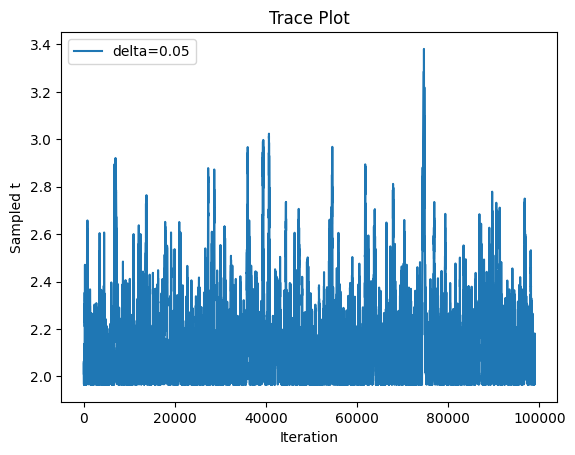

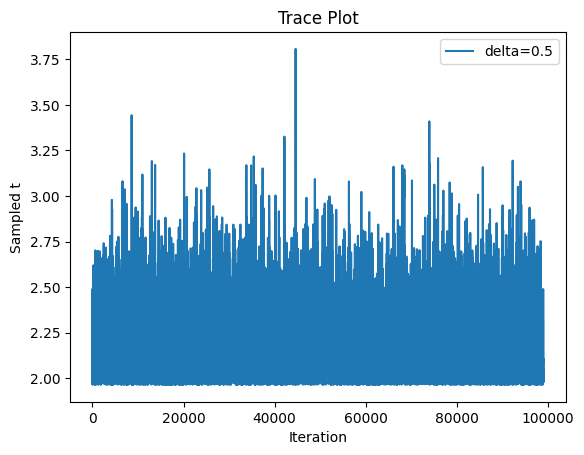

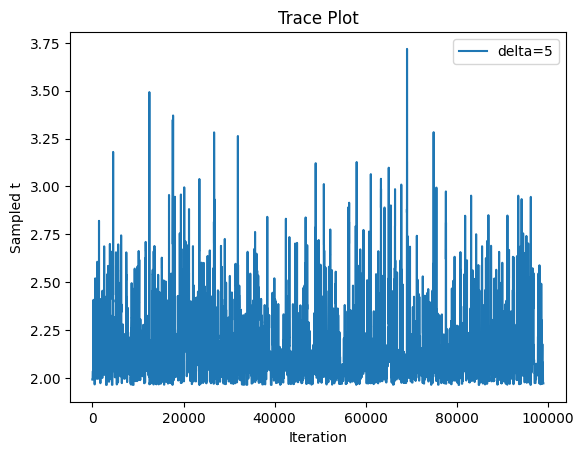

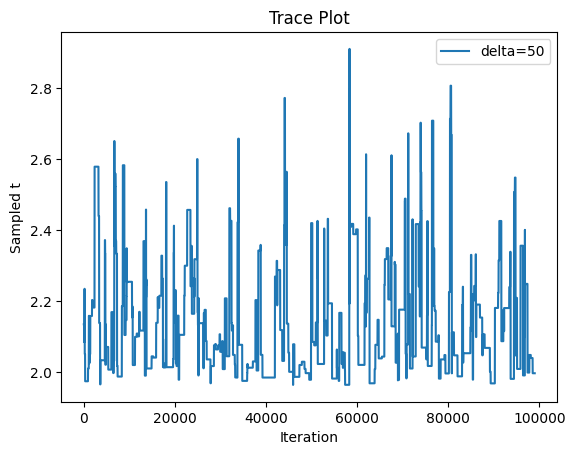

In [4]:
for delta in deltas:
    samples, acceptance_rate = metropolis_hastings(n, x_max, delta, M, burn_in)
    
    plt.plot(samples, label=f'delta={delta}')
    plt.ylabel('Sampled t')
    plt.xlabel('Iteration')
    plt.title('Trace Plot')
    plt.legend()
    plt.show()

As $\delta$ increases, the traces become smoother. This is because the corresponding acceptance rates get lower.

The range of sampled $t$ values is smaller for the two extreme values of $\delta$: $\delta=0.05$ and $\delta=50$.

$\delta=0.5$ yielded a post-burn-in acceptance rate closest to 25%.

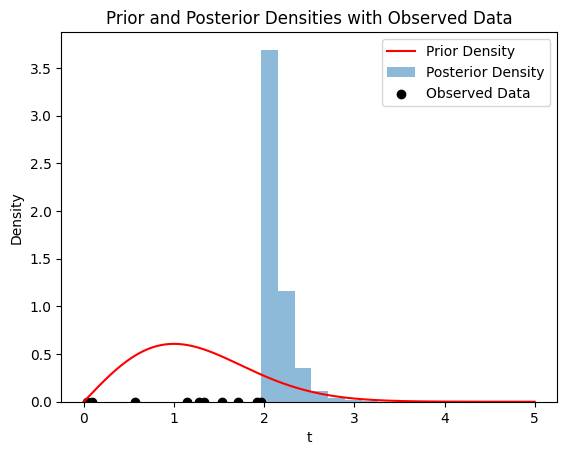

In [5]:
def prior_density(t):
    '''Compute the prior probability density function.'''
    return t * np.exp(-0.5 * t**2)

# Plot the prior probability density function
t_values = np.linspace(0, 5, 1000)
prior_values = prior_density(t_values)
plt.plot(t_values, prior_values, color='r', label='Prior Density')

delta = 0.5
samples, acceptance_rate = metropolis_hastings(n, x_max, delta, M, burn_in)
# Plot a histogram of the samples as an estimate of the posterior density
plt.hist(samples, bins=10, density=True, alpha=0.5, label='Posterior Density')

# Mark the observed data values from x on the horizontal axis
plt.scatter(x, np.zeros_like(x), color='black', label='Observed Data')

plt.ylabel('Density')
plt.xlabel('t')
plt.title('Prior and Posterior Densities with Observed Data')
plt.legend()
plt.show()

In [6]:
# Calculate the 2.5-th and 97.5-th percentiles of samples
lower_bound = np.percentile(samples, 2.5)
upper_bound = np.percentile(samples, 97.5)
print('95% posterior credible interval for t:', [lower_bound, upper_bound])

95% posterior credible interval for t: [1.9680679298191834, 2.565727278757683]


In [7]:
# Take the median of samples
posterior_median = np.median(samples)
print('Estimated t assuming the absolute value loss function:', posterior_median)

Estimated t assuming the absolute value loss function: 2.074043503294454


In [8]:
# Calculate the naive Monte Carlo estimate from samples
posterior_probability = np.mean(samples >= 4)
print('Naive Monte Carlo estimate of the posterior probability that t >= 4:', posterior_probability)

Naive Monte Carlo estimate of the posterior probability that t >= 4: 0.0


This is clearly inaccurate: the probability must be non-zero, just very small. This could be remedied by taking a larger sample.

I will adapt the Metropolis-Hastings sampling code to calculate a Monte Carlo estimate of the posterior conditional expectation $\mathbb{E}_\pi(t \mid t \geq 4)$.

The only change that we need to make to the Metropolis Hastings sampling code is

$$
\pi (t) \propto t^{1-n} \exp \left( -\frac {1} {2} t^2 \right) \mathbb{1}_{[4, \infty)}(t).
$$

In [9]:
def pi(t, n, x_max):
    '''Compute the (unnormalised) posterior density, given that t >= 4.'''
    if t >= 4:
        return t**(1-n) * np.exp(-0.5 * t**2)
    else:
        return 0

samples, acceptance_rate = metropolis_hastings(n, x_max, delta, M, burn_in)

In [10]:
# Calculate the Monte Carlo estimate of the posterior conditional expectation
posterior_conditional_expectation = np.mean(samples)
print('Monte Carlo Estimate of E(t | t >= 4):', posterior_conditional_expectation)

Monte Carlo Estimate of E(t | t >= 4): 4.154319678770311
